In [22]:
from dotenv import load_dotenv; load_dotenv()

True

# Operational Aspects of the RAG Application

## Logging requests

In order to improve the performance of the RAG application it is crucial that we log each request so we can study what to improve. To make parsing of the data easier, we use the Python `structlog` package. First we need to configure the logging, which happens in `rag/serve.py`. We are storing the logs in a network file system, configured via the `RAY_ASSISTANT_LOGS` environment variable and make sure a timestamp is written for each log line. The logs are then rendered as JSON lines and written to the log file:

```python
# Configure logging
logging.basicConfig(filename=os.environ["RAY_ASSISTANT_LOGS"], level=logging.INFO, encoding='utf-8')
structlog.configure(
    processors=[
        structlog.processors.TimeStamper(fmt="iso"),
        structlog.processors.JSONRenderer(),
    ],
    logger_factory=structlog.stdlib.LoggerFactory(),
)
logger = structlog.get_logger()
```

The actual call that records the log then looks like the following:

```python
logger.info(
    "finished streaming query",
    query=query,
    document_ids=result["document_ids"],
    llm=result["llm"],
    answer=answer
)
```

Depending on your application, it might make sense to add more fields to the logs -- we are logging the user's `query`, the document IDs retrieved from the database that make up the context as well as the LLM that was used for answering the query.

## Evaluating the data

In [4]:
import json

records = []
log_prefix = "INFO:rag.serve:"
with open("/mnt/shared_storage/ray-assistant-logs/info.copy") as f:
    records = [json.loads(line.removeprefix(log_prefix)) for line in f if line.startswith(log_prefix)]

In [14]:
import pandas as pd

df = pd.DataFrame.from_records(records)
df['timestamp']= pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [15]:
df

,query,document_ids,llm,answer,event
timestamp,,,,,
2023-09-16 05:56:12.792456+00:00,Give me a code example for creating an actor.,"[3689, 9659, 3746, 11936, 3854, 4549, 3748]",gpt-4,Here is a Python code example for creating an ...,finished streaming query
2023-09-16 06:04:57.823437+00:00,What is Ray?,"[4538, 3471, 11362, 8371, 4445, 8271, 5358]",meta-llama/Llama-2-70b-chat-hf,Ray is a framework for running arbitrary code ...,finished streaming query
2023-09-16 06:13:44.251850+00:00,How can I read all text files from the bucket ...,"[6102, 6388, 6571, 6706, 7458, 5701, 6188]",meta-llama/Llama-2-70b-chat-hf,"To read all text files from the bucket ""s3://r...",finished streaming query
2023-09-16 06:14:15.046320+00:00,How can I read all text files from the bucket ...,"[6706, 6187, 6188, 6102, 6140, 6388, 6571]",meta-llama/Llama-2-70b-chat-hf,Sure! Here's a succinct answer to the query:\n...,finished streaming query
2023-09-16 06:14:31.911983+00:00,How can I read all text files from the bucket ...,"[6706, 6102, 6187, 6388, 6188, 5685, 6140]",meta-llama/Llama-2-70b-chat-hf,"To read all text files from the bucket ""s3://r...",finished streaming query
...,...,...,...,...,...
2023-09-26 22:39:06.602940+00:00,how to install all ray dependencies at once\n\n,"[4568, 8012, 3550, 640, 461]",meta-llama/Llama-2-70b-chat-hf,"To install all Ray dependencies at once, you ...",finished streaming query
2023-09-26 22:46:16.754912+00:00,what are the different Trainers available?,"[12001, 7375, 7087, 7043, 7001]",meta-llama/Llama-2-70b-chat-hf,The different Trainers available are:\n\n* Ba...,finished streaming query
2023-09-26 22:49:30.055570+00:00,connect worker to already existing cluster\n\n,"[5248, 3980, 5270, 4430, 5355]",meta-llama/Llama-2-70b-chat-hf,To connect a worker node to an existing Ray c...,finished streaming query


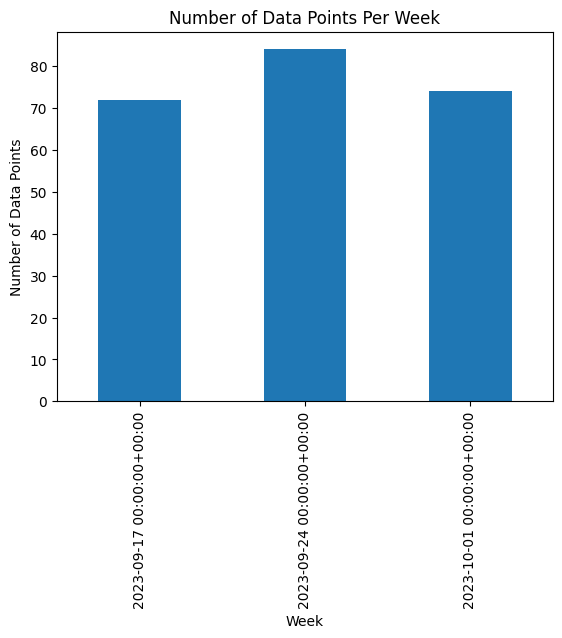

In [16]:
import matplotlib.pyplot as plt

# Resample the DataFrame by week and count the number of data points
weekly_counts = df.resample('W').size()

# Plot the bar chart
weekly_counts.plot(kind='bar')

# Customize the plot
plt.title('Number of Data Points Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Data Points')

# Show the plot
plt.show()

In [19]:
(df["llm"] == "gpt-4").sum()

63

## Investigate retrieved contexts for each request

In [26]:
import psycopg

def retrieve_document(document_id):
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM document WHERE id = %s", (document_id,))
            row = cur.fetchone()
            return {"text": row[1], "source": row[2]}

{'text': 'No speedup#\nYou just ran an application using Ray, but it wasn’t as fast as you expected it\nto be. Or worse, perhaps it was slower than the serial version of the\napplication! The most common reasons are the following.\nNumber of cores: How many cores is Ray using? When you start Ray, it will\ndetermine the number of CPUs on each machine with psutil.cpu_count(). Ray\nusually will not schedule more tasks in parallel than the number of CPUs. So\nif the number of CPUs is 4, the most you should expect is a 4x speedup.\nPhysical versus logical CPUs: Do the machines you’re running on have fewer\nphysical cores than logical cores? You can check the number of logical\ncores with psutil.cpu_count() and the number of physical cores with\npsutil.cpu_count(logical=False). This is common on a lot of machines and\nespecially on EC2. For many workloads (especially numerical workloads), you',
 'source': 'https://docs.ray.io/en/master/ray-observability/user-guides/debug-apps/optimize-perfor

In [35]:
idx = -2
print("query", df.iloc[idx]["query"])
for document_id in df.iloc[idx]["document_ids"]:
    print(retrieve_document(document_id))

query Can I use deepspeed with ray serve?
{'text': 'Running DeepSpeed with other frameworks#\nMany deep learning frameworks have integrated with DeepSpeed, including Lightning, Transformers, Accelerate, and more. You can run all these combinations in Ray Train.\nPlease check the below examples for more details:\nFramework\nExample\n\n\n\nAccelelate (User Guide)\nFine-tune Llama-2 series models with Deepspeed, Accelerate, and Ray Train.\n\nTransformers (User Guide)\nFine-tune GPT-J-6b with DeepSpeed and Hugging Face Transformers\n\nLightning (User Guide)\nFine-tune vicuna-13b with DeepSpeed and PyTorch Lightning', 'source': 'https://docs.ray.io/en/master/train/deepspeed.html#running-deepspeed-with-other-frameworks'}
{'text': '🤗 Transformers and Ray Train’s integrations allow you to easily configure and use DDP and DeepSpeed. All you need to do is specify the DeepSpeed configuration in the TrainingArguments object.\nTip\nThere are many DeepSpeed settings that allow you to trade-off speed